In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
import numpy as np
import csv
import os
import datetime
import dateutil.parser as parser
import matplotlib.pyplot as plt
from matplotlib.finance import *
from sklearn.model_selection import train_test_split

In [161]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

In [212]:
import statsmodels.tsa.arima_model as arima

In [374]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

In [606]:
np.random.seed(42)

y_true = smt.arma_generate_sample([0.02, 0.01], [0.4, 0.35, 0.25], 1000, sigma=0.1, burnin=100).cumsum()

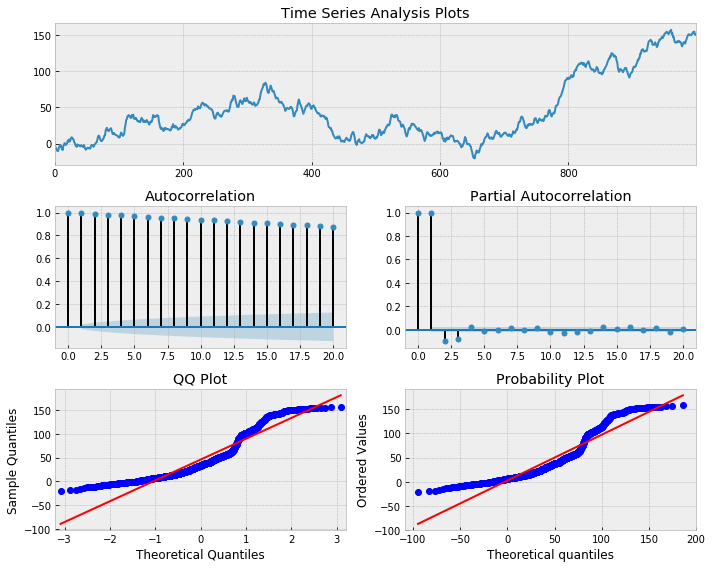

In [607]:
tsplot(y_true, lags=20)

In [608]:
mdl = smt.ARIMA(y_true, (2, 1, 3)).fit(maxlag=10, ic='aic', trend='nc')
print("AR: %s, MA: %s" % (mdl.arparams, mdl.maparams))

AR: [-0.2949419  0.092406 ], MA: [ 0.65850084  0.45115766 -0.10473017]


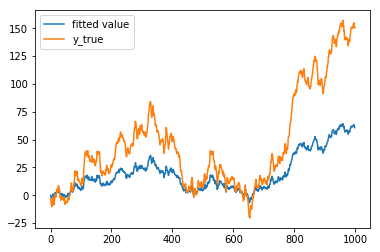

In [610]:
plt.plot(mdl.fittedvalues.cumsum(), label='fitted value')
plt.plot(y_true, label='y_true')
plt.legend()

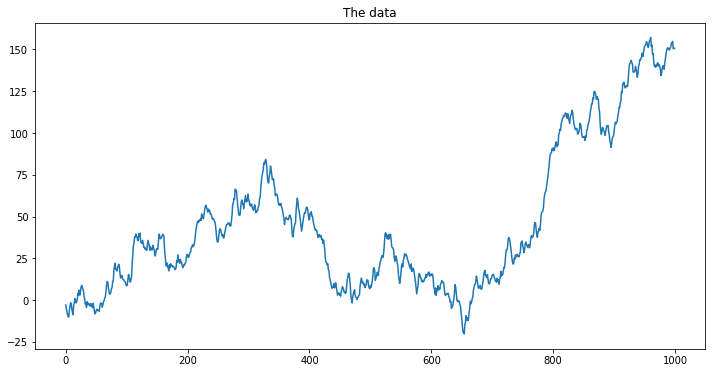

In [611]:
plt.figure(figsize=(12, 6))
plt.plot(y_true)
plt.title("The data")

In [612]:
train_length = int(0.5 * len(y_true))
data_length = len(y_true)

In [613]:
y_train = y_true[:train_length]
y_test = y_true[train_length:]

In [614]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, window=5):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=window, center=True, min_periods=1)
    rolstd = pd.rolling_std(timeseries, window=window, center=True, min_periods=1)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Data')
    mean = plt.plot(rolmean, color='red', label='Mean Average(%d)' % window)
    ##std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Mean Average')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
        
    print(dfoutput)

### Test for stationarity using the Dickey-Fuller Test
- showing the rolling mean and the rolling standard deviation with window 120

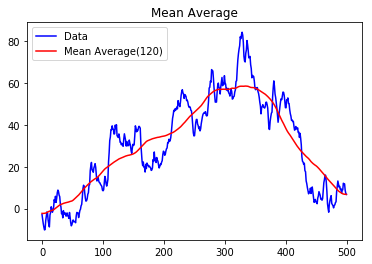

Results of Dickey-Fuller Test:
Test Statistic                  -1.614348
p-value                          0.475694
#Lags Used                       6.000000
Number of Observations Used    493.000000
Critical Value (1%)             -3.443684
Critical Value (10%)            -2.569902
Critical Value (5%)             -2.867420
dtype: float64


In [615]:
test_stationarity(y_train, window=120)

There is an obvious rising trend in our data. We can remove it by subtracting the moving average from y.

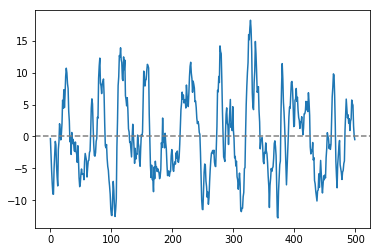

In [625]:
y_ma = pd.rolling_mean(y_train, window=50, center=True, min_periods=1)
y_no_lag = y_train - y_ma
plt.plot(y_no_lag)
#plt.plot(pd.rolling_mean(y_no_lag, window=10, center=True, min_periods=1))
plt.axhline(y=0.0, linestyle='--', color='gray')

The series looks stationary now.

In [626]:
from statsmodels.tsa.arima_model import ARIMA

In [627]:
y_test_ma = pd.rolling_mean(y_test, window=120, center=True, min_periods=1)
y_test_no_lag = y_test - y_test_ma

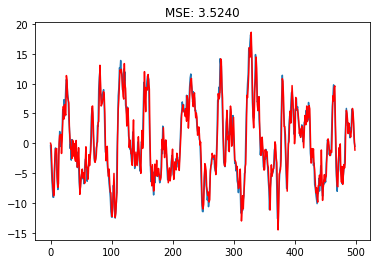

In [629]:
model = ARIMA(y_no_lag, order=(2, 0, 3))  
results_AR = model.fit(disp=-1)
plt.plot(y_no_lag)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('MSE: %.4f'% sum((results_AR.fittedvalues-y_no_lag)**2/train_length))

In [630]:
y_pred = results_AR.predict(train_length, data_length-1)

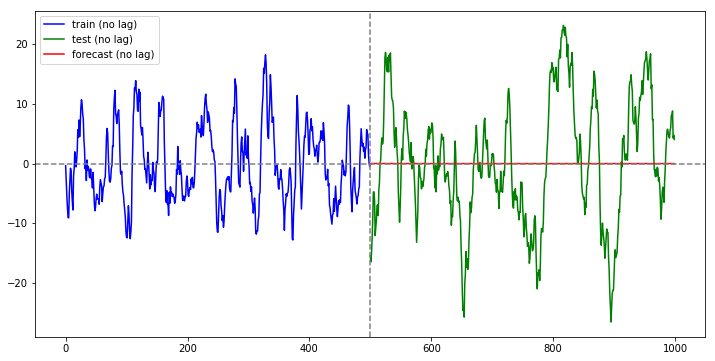

In [631]:
plt.figure(figsize=(12, 6))
plt.plot(np.arange(train_length), y_no_lag, color='b', label="train (no lag)")
plt.plot(np.arange(train_length, data_length), y_test_no_lag, color='g',label="test (no lag)")
plt.plot(np.arange(train_length, data_length), y_pred, color='r', label="forecast (no lag)")
plt.axvline(x=train_length,linestyle='--',color='gray')
plt.axhline(y=0.0,linestyle='--',color='gray')
plt.legend()

Ok, but what if we don't want to explicitely remove moving average ?

We can try to differentiate the function assuming the trend is linear.

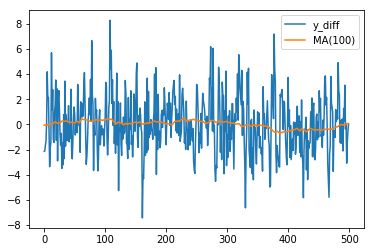

In [632]:
y_diff = np.concatenate([np.diff(y_train), [0]])
plt.plot(y_diff, label="y_diff")
plt.plot(pd.rolling_mean(y_diff, 100, center=True, min_periods=1), label="MA(100)")
plt.legend()

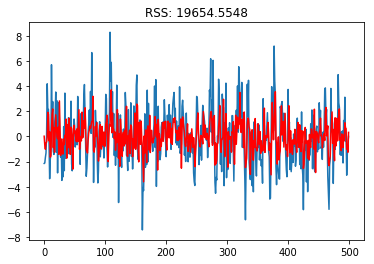

In [637]:
model = ARIMA(y_diff, order=(2, 0, 3))
results_AR = model.fit(disp=-1)
plt.plot(y_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-y_no_lag)**2))

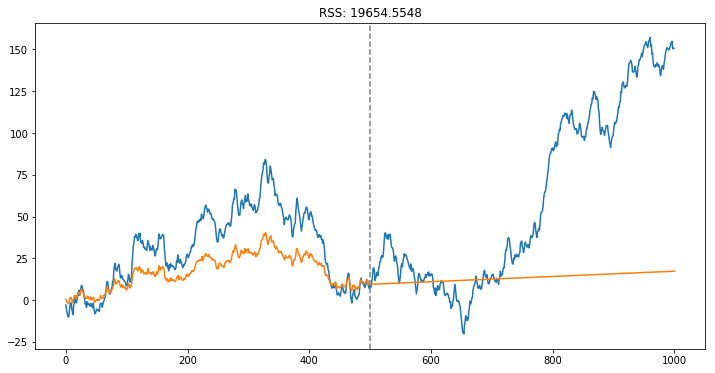

In [638]:
plt.figure(figsize=(12, 6))
y_pred = results_AR.predict(train_length, data_length)
plt.plot(np.concatenate([y_train, y_test]))
plt.plot(0.5+np.concatenate([results_AR.fittedvalues, y_pred]).cumsum())
plt.axvline(x=train_length,linestyle='--',color='gray')
#plt.plot(results_AR.fittedvalues.cumsum(), color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-y_no_lag)**2))

Let ARIMA do the differentiation for us (set d = 1)

In [654]:
model = ARIMA(y_train, order=(1, 1, 2))
results_AR = model.fit(disp=-1, method='mle')
print('MSE: %.4f'% sum((results_AR.fittedvalues-y_train[:-1])**2/train_length))

MSE: 1454.2027


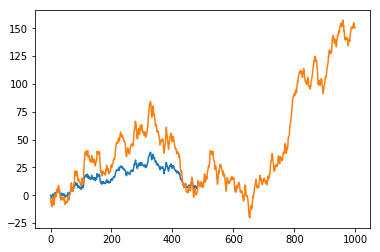

In [655]:
plt.plot(results_AR.fittedvalues.cumsum())
plt.plot(y_true)

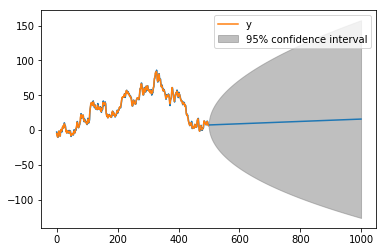

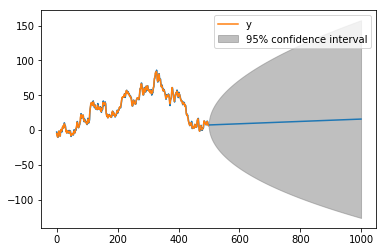

In [689]:
results_AR.plot_predict(1, data_length)

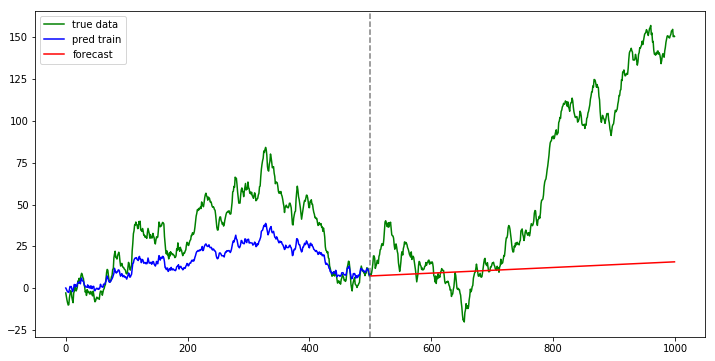

In [690]:
plt.figure(figsize=(12, 6))
plt.plot(np.concatenate([y_train, y_test]), color='g', label="true data")
y_pred, y_stderr, y_conf = results_AR.forecast(data_length-train_length+1)
y_pred_cm = np.concatenate([results_AR.fittedvalues.cumsum(), y_pred])
plt.plot(np.arange(train_length), y_pred_cm[:train_length], color='b', label="pred train")
plt.plot(np.arange(train_length, data_length), y_pred_cm[train_length:], color='r', label="forecast")
plt.axvline(x=train_length,linestyle='--',color='gray')
plt.legend()

In [658]:
results_AR.arparams, results_AR.maparams, results_AR.k_diff

(array([-0.40756524]), array([0.76669513, 0.56249418]), 1)

# Looks good, but how do we choose p, d and q ?

Plot the _Autocorrelation Function_ and the _Partial Autocorrelation Function_ for different lag values.

The Autocorrelation shows 

In [659]:
from statsmodels.tsa.stattools import acf, pacf

In [660]:
lag_acf = acf(y_diff, nlags=20)
lag_pacf = pacf(y_diff, nlags=20, method='ols')

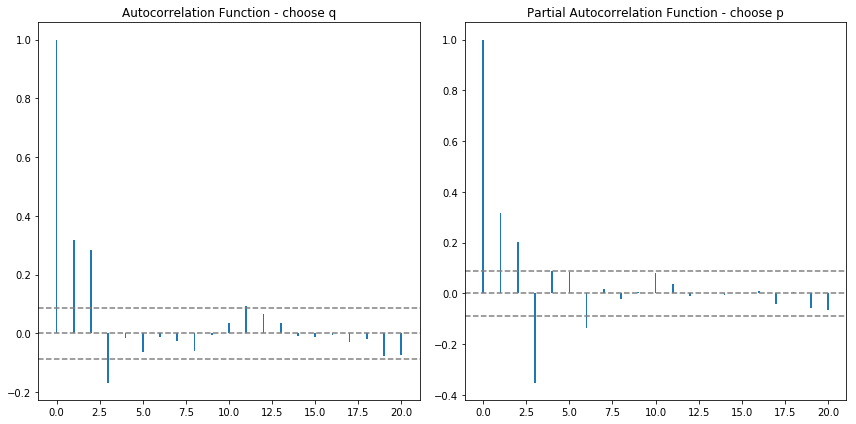

In [661]:
plt.figure(figsize=(12, 6))
plt.subplot(121) 
plt.bar(np.arange(len(lag_acf)), lag_acf, width=0.1)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function - choose q')

plt.subplot(122)
plt.bar(np.arange(len(lag_pacf)), lag_pacf, width=0.1)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function - choose p')
plt.tight_layout()